In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
import csv
import numpy as np
import sklearn
import glob
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# PREPROCESADO DE LOS DATOS

### COMPARACIÓN ENTRE LA CARPETA PACIENTES Y EL CSV PACIENTES_PROGRESORES

**CONTENIDO**:
    
* En la carpeta **pacientes** tengo 1794 ficheros nombrados con el número de historia de cada paciente, cada fichero contiene las mediciones que se han hecho a cada paciente en X revisiones.    

* En el csv **pacientes_progresores** tengo dos columnas. La primera columna es el número de historia clínica del pacientes y la segunda columna toma valores 0 o 1, siendo el 0 pacientes no progresores y el 1 pacientes progresores.

**OBJETIVO**:

* El primer paso es detectar que pacientes de mi carpeta **pacientes** se encuentra en el csv **pacientes_progresores**, ya que el número de pacientes en la carpeta es mayor que en el csv.


**PASOS**:

* Almaceno en una lista llamada pacientes_independientes todos los ficheros de la carpeta **pacientes**
* Creo una lista llamada pacientes_progresores a partir del csv **pacientes_progresores**

In [3]:
import os
#contenido = os.listdir('C:/Users/ywen2/Desktop/URJC/TFG/TFG_GITHUB/ddbb/pacientes')
contenido = os.listdir('../ddbb/pacientes')

In [4]:
lista_id_indep =  [item.replace(".csv", "") for item in contenido] #Elimino .csv para quedarme solo el Nº de historia y poder 
#comparar mas fácilmente con el csv pacientes_progresores

#Convierto la lista a CSV
pacientes_independientes = pd.DataFrame(lista_id_indep, columns=["Pacientes"])
pacientes_independientes.to_csv('pacientes_indep.csv', index=False)

#Convierto el CSV a una lista nuevamente
df_independientes = pd.read_csv('pacientes_indep.csv').fillna(0)
pacientes_independientes = df_independientes.iloc[:,0]
pacientes_independientes = list(pacientes_independientes)

#### Creo una lista a partir del csv: pacientes_progresores

In [5]:
#csv_filename = 'C:/Users/ywen2/Desktop/URJC/TFG/TFG_GITHUB/ddbb/pacientes_progresores.csv'
csv_filename = '../ddbb/pacientes_progresores.csv'

with open(csv_filename, 'r') as archivo:
    leer = csv.reader(archivo)
    lista = list(leer)
    lista.pop(0)

In [6]:
df = pd.DataFrame (lista,columns=['Historia','Progresion'])
print (df)

     Historia Progresion
0      100220          1
1      100257          0
2       10045          0
3      100505          0
4      100598          0
...       ...        ...
1642    99582          0
1643     9970          0
1644    99828          1
1645    99835          0
1646     9985          0

[1647 rows x 2 columns]


In [7]:
#df_progresores = pd.read_csv('C:/Users/ywen2/Desktop/URJC/TFG/TFG_GITHUB/ddbb/pacientes_progresores.csv').fillna(0)
df_progresores = pd.read_csv(csv_filename).fillna(0)
pacientes_progresores = df_progresores.iloc[:,0]
pacientes_progresores = list(pacientes_progresores)

* Comparo ambas listas y añado a una nueva lista llamada **comparación** aquel paciente que existe en ambas

In [8]:
comparacion = []
 
for item in pacientes_independientes:
    if item in pacientes_progresores:
        comparacion.append(item)

* Creo un csv llamado df_procesados, añadiendo a la columna historia el numero de historia de aquellos pacientes que están en la lista comparación, es decir, que estan tanto en la carpeta pacientes como en el csv pacientes_progresores

In [9]:
df_procesados = pd.DataFrame(comparacion, columns=["Historia"])
print(df_procesados)
df_procesados.to_csv('pacientes_procesados.csv', index=False)

      Historia
0       139201
1       373199
2       296856
3       173427
4         3942
...        ...
1642     42439
1643    128011
1644     69198
1645     50927
1646    213635

[1647 rows x 1 columns]


* Comparo el dataframe df creado por mi con el dataframe creado a partir del csv pacientes_progresores original y compruebo si coinciden todos los valores, de modo que si coinciden podemos concluir diciendo que en el csv pacientes_progresores están todos los pacientes con los que debemos trabajar.

In [10]:
file1 = df['Historia'].astype(int)
file2 = df_procesados['Historia'].astype(int)

In [11]:
mergedStuff = pd.merge(file1, file2, how='inner', indicator = 'union')
print(mergedStuff)

contador = 0
for i in mergedStuff['union']:
    if i != 'both':
        contador += 1
        
print(contador)

      Historia union
0       100220  both
1       100257  both
2        10045  both
3       100505  both
4       100598  both
...        ...   ...
1642     99582  both
1643      9970  both
1644     99828  both
1645     99835  both
1646      9985  both

[1647 rows x 2 columns]
0


* Vemos que los pacientes coinciden en ambos csv (el contador es igual a 0), por lo que podemos concluir diciendo que en el csv pacientes_progresores tenemos los pacientes con los que vamos a trabajar.

## FUNCTION TO OBTAIN IF A PATIENT IS PREDIABETIC OR NOT

In [12]:
def get_pat(idd,path='../ddbb/pacientes/'):
    
    file = df.values.tolist()
    paciente = pd.read_csv(path + idd+'.csv')
    for i in file:
        if i[0] == idd:
            print('El paciente presenta la siguiente etiqueta:', i[1])
    return(paciente)
    
    #lee fichero de ese id

In [13]:
paciente = get_pat('100220')

El paciente presenta la siguiente etiqueta: 1


## FUNCTION TO OBTAIN THE MATRICES OF PROGRESSING AND NON-PROGRESSING PATIENTS

* Función con la que obtenemos las matrices tanto de pacientes progresores como de no progresores

In [14]:
def get_matrix():
    progresores = []
    no_progresores = []
    fila = []
    for i in df.index:
        if df['Progresion'][i] == '1':
             progresores.append((df['Historia'][i]))
        else:
            no_progresores.append((df['Historia'][i]))

    row_max = 0
    row_max_1 = 0
    matrices = [] #list of matrices. Each list element is a matrix for one patient, with rows = reviews, cols = features
    matrices_1 = [] #list of matrices. Each list element is a matrix for one patient, with rows = reviews, cols = features

    for paciente in progresores:
            pacientes = pd.read_csv('../ddbb/pacientes/' + paciente+'.csv',usecols = list(range(22))) #dataframe con variables.
            #remove last column (date) --> list(range(22))
            matrix_pat = pacientes.to_numpy() #one patient matrix
            matrices.append(matrix_pat)
            #print(len(matrices))

            #get the maximum number of rows : it is the maximum number of reviews for a given patient.
            filas = matrix_pat.shape[0]
            if filas > row_max:
                row_max = filas


    for paciente in no_progresores:
        pacientes = pd.read_csv('../ddbb/pacientes/' + paciente+'.csv',usecols = list(range(22)))
            #remove last column (date)
        matrix_pat_1 = pacientes.to_numpy() #one patient matrix
        matrices_1.append(matrix_pat_1)
            #print(len(matrices))

            #get the maximum number of rows : it is the maiximum number of reviews for a given patient.
        filas_1 = matrix_pat_1.shape[0]
        if filas_1 > row_max_1:
            row_max_1 = filas_1


      #build complete matrix

    X_progresores = np.zeros((len(matrices),row_max,22))
    X_progresores[:,:,:] = np.nan

    for i,mat in enumerate(matrices):
        X_progresores[i,:mat.shape[0],:] = mat

    X_no_progresores = np.zeros((len(matrices_1),row_max_1,22))
    X_no_progresores[:,:,:] = np.nan

    for i,mat_1 in enumerate(matrices_1):
        X_no_progresores[i,:mat_1.shape[0],:] = mat_1

    
    
    return X_progresores, X_no_progresores

In [15]:
matriz_progresores, matriz_no_progresores = get_matrix()

# ¿POR QUÉ PLOTEAMOS HASTA LA REVISIÓN 20?

## PLOTTING MEAN VALUES FOR EACH FEATURE ALONG THE REVIEWS

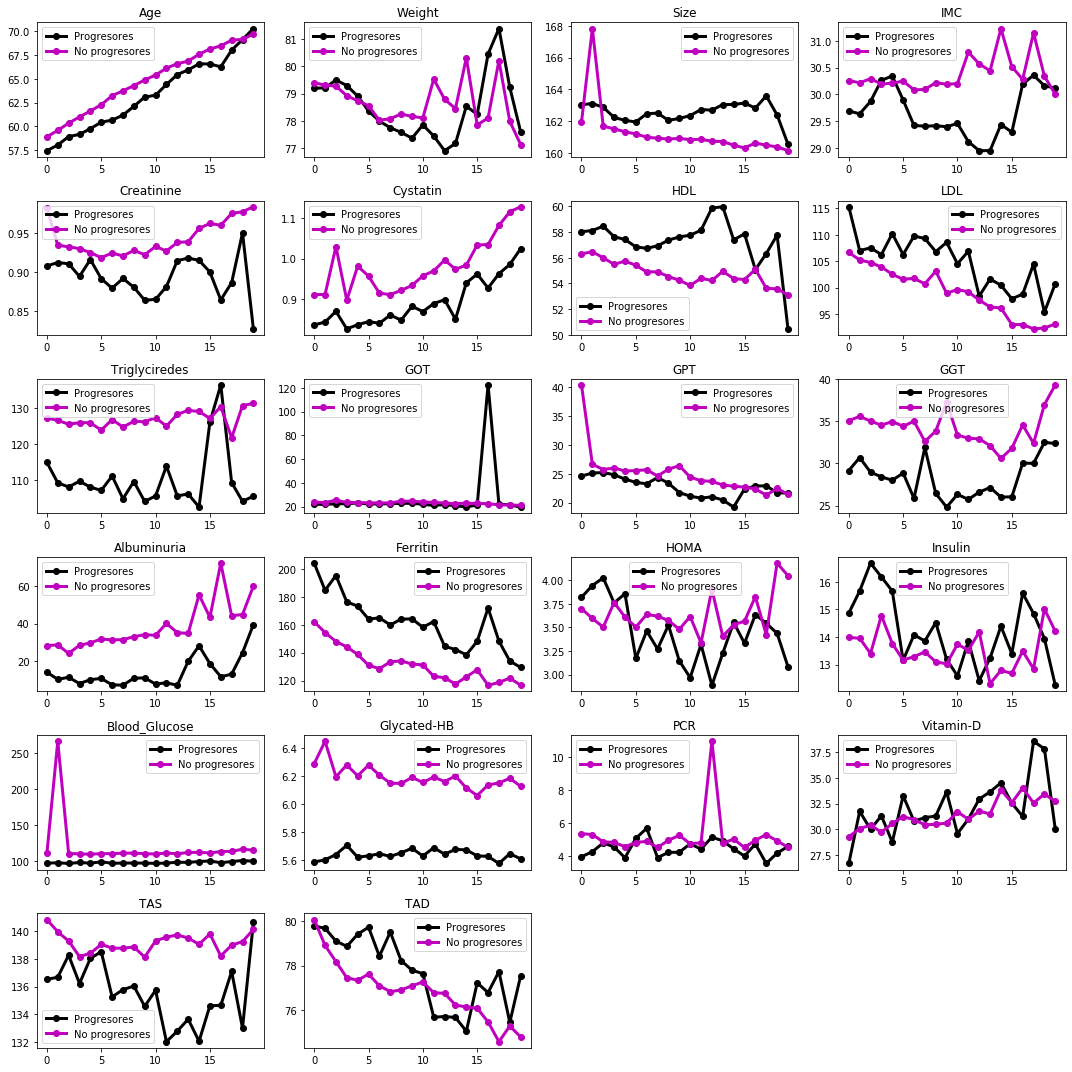

In [16]:
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
plt.figure(figsize = (15,15))
for i in range(len(feature_names)-1):

    plt.subplot(6,4,i+1)  
    plt.plot(np.nanmean(matriz_progresores[:,:20,i],axis = 0),'k-o',linewidth = 3,label = 'Progresores')
    plt.plot(np.nanmean(matriz_no_progresores[:,:20,i],axis = 0),'m-o',linewidth = 3,label = 'No progresores') 
    plt.title(feature_names[i])
    plt.legend()

plt.tight_layout()

* CUANTOS PACIENTES TIENEN MÁS DEL MAXIMO DE REVISIONES DE LOS PROGRESORES
* TABLA/GRAFICA DE PACIENTES PROGRESORES Y NO PROGRESORES SEGUN EL NÚMERO DE REVISIONES

* EN AQUELLAS GRÁFICAS QUE HAY PICOS REVISAR, Vamos a ver todas las revisiones para cada features en un jupyternotebooo diferente
* Para todas las revisiones:PINTAR HISTOGRAMA O BOX PLOT 
* MATRIZ CON LAS MISMAS DIMENSIONES QUE MATRIZ NO/PROGRESORES. LA CREO CON TODO TRUE, EN CADA FEATURE Y REVISION QUE MODIFIQUE 

* PINTAR GRAFICAS SIN LOS OUTLIERS.

* Número de pacientes por revisión!!!

## OBTAINING THE MATRIX OF INDICES

#### MATRIZ DE ÍNDICES

* Matriz *idxn* con True en las posiciones con Nan. Tiene dimensiones: $NxRxD$, donde $N =$ número de pacientes, $R = $ número de revisión, $D = $ número de características
* Matrix *idxoutl* con True en las posiciones con outliers. Tiene dimensiones: $NxRxD$, donde $N =$ número de pacientes, $R = $ número de revisión, $D = $ número de características
* Matriz *idx* es la matriz con Trues en la posiciones con valores válidos y False en aquellos que son NaN o bien outliers y que se tienen que imputar en su momento.

In [17]:
# Create the matrix
idxn_no_prog = np.isnan(matriz_no_progresores) #Matriz con True en las posiciones donde hay NaN
idxoutl_no_prog = np.empty(matriz_no_progresores.shape,'bool')
idxoutl_no_prog[:] = False


idxn_prog = np.isnan(matriz_progresores)
idxoutl_prog = np.empty(matriz_progresores.shape,'bool')
idxoutl_prog[:] = False

#checking sizes 

print('no progresores')
print(idxn_no_prog.shape)
print(idxoutl_no_prog.shape)
print(np.sum(idxn_no_prog))
print(idxoutl_no_prog.shape)
print(np.sum(idxoutl_no_prog))

print('progresores')
print(idxn_prog.shape)
print(idxoutl_prog.shape)
print(np.sum(idxn_prog))
print(idxoutl_prog.shape)
print(np.sum(idxoutl_prog))



no progresores
(1515, 33, 22)
(1515, 33, 22)
803459
(1515, 33, 22)
0
progresores
(132, 22, 22)
(132, 22, 22)
37041
(132, 22, 22)
0


In [88]:
outliers_limits = [(20,90),(45,200),(120,210),(10,50),(0,4),
                   (0,6),(10,300),(10,300),(50,750),(20,200),
                   (20,200),(0,300),(0,3000),(15,3000),(0,60),
                   (0,100),(40,400),(2,15),(0,200),(0,80),
                   (90,220),(40,150)]

In [89]:
for i in range(len(outliers_limits)):
    #actualizar las posiciones en las que hay outliers para cada feature
    idxoutl_prog[:,:,i] = (matriz_progresores[:,:,i] < outliers_limits[i][0]) | (matriz_progresores[:,:,i] > outliers_limits[i][1])
    idxoutl_no_prog[:,:,i] = (matriz_no_progresores[:,:,i] < outliers_limits[i][0]) | (matriz_no_progresores[:,:,i] > outliers_limits[i][1])
 
#creamos matrices completas de índices para progresores y no progresores: true en las posiciones con valores reales y
# false en valores nan o outliers

idx_matrix_prog = (~idxn_prog)&(~idxoutl_prog)
idx_matrix_no_prog = (~idxn_no_prog)&(~idxoutl_no_prog)

#check sizes
print('no progresores')
print(print(np.sum(idx_matrix_no_prog[:,1,16])))
print(idx_matrix_no_prog.shape)
print(np.sum(idx_matrix_no_prog))

print('progresores')
print(matriz_progresores.shape)
print(idx_matrix_prog.shape)
print(np.sum(idx_matrix_prog))

no progresores
1507
None
(1515, 33, 22)
283339
progresores
(132, 22, 22)
(132, 22, 22)
25632


## Pintar figuras por feature eliminando los valores  que son outliers y nan

A continuación representamos de forma conjunta el valor medio de los pacientes para cada revisión (separados por features), sin incluir los valores considerados como NaN ni outliers

In [90]:
#get mean value per review and feature
idx_matrix_prog[:,0,0].shape

(132,)

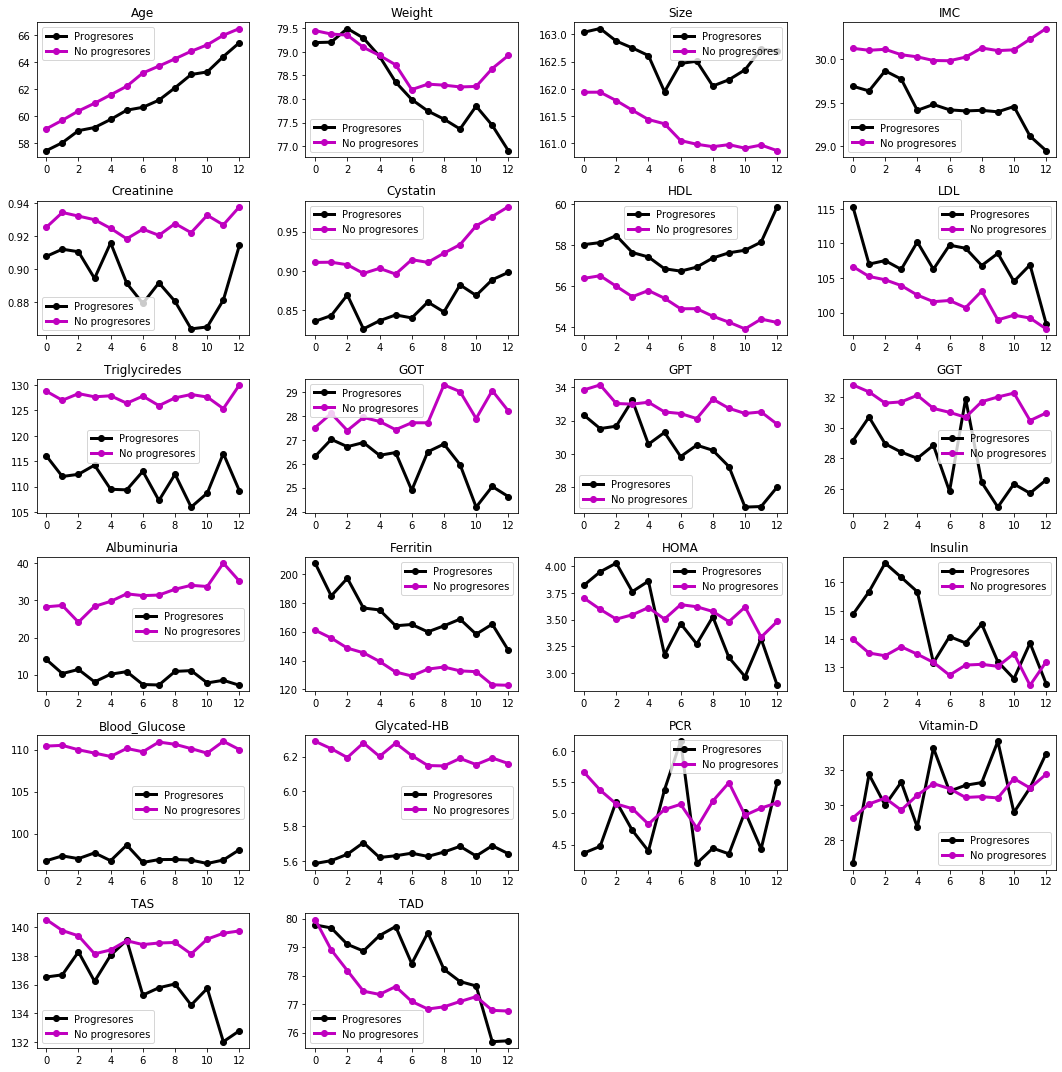

In [93]:
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
plt.figure(figsize = (15,15))


for i in range(len(feature_names)-1):

    m_rev_prog = []
    m_rev_no_prog = []
    #mean value per review
    for j in range(13): #13 review seems to be the best option
        aux_m = np.mean(matriz_progresores[idx_matrix_prog[:,j,i],j,i],axis = 0)
        m_rev_prog.append(aux_m)
        
        aux_m_n = np.mean(matriz_no_progresores[idx_matrix_no_prog[:,j,i],j,i],axis = 0)
        m_rev_no_prog.append(aux_m_n)
    

    plt.subplot(6,4,i+1)  
    plt.plot(m_rev_prog,'k-o',linewidth = 3,label = 'Progresores')
    plt.plot(m_rev_no_prog,'m-o',linewidth = 3,label = 'No progresores') 
    plt.title(feature_names[i])
    plt.legend()

plt.tight_layout()


## TODO: cbarquero

Ahora habría que checkear que si se pinta toda la información sólo para los valores que idx_matrix_x son true, para cada característica se encuentra dntro de los rangos válidos para cada feature

In [ ]:
#plt.boxplot(matriz_no_progresores[:,1,17])
idxn = np.isnan(matriz_no_progresores[:,1,16]) #vector con True donde hay NAN
idxoutl = (matriz_no_progresores[:,1,16] < 200) & (matriz_no_progresores[:,1,16] > 50)

In [ ]:
plt.boxplot(matriz_no_progresores[(~idxn)&(idxoutl),1,16]) 

In [ ]:
idx_no_progresores = np.zeros(matriz_no_progresores.shape, dtype=bool)
idx_no_progresores[:,:,:] = True
idx_no_progresores[:,1,16] = (~idxn)&(idxoutl)
print(idx_no_progresores[:,1,16])

In [ ]:
gluc_mean = []
for i in range(30): 
    aux = np.nanmean(matriz_no_progresores[idx_no_progresores[:,i,16],i,16]) #COJO LOS PACIENTES QUE NO SON NI NAN NI MAYORES > 20 y HAGO LA MEDIA 
    gluc_mean.append(aux)

In [ ]:
plt.plot(gluc_mean)

Plotting blood glucose

In [ ]:
np.save('Matriz_progresores', matriz_progresores)
np.save('Matriz_no_progresores', matriz_no_progresores)

In [ ]:
##UN JUPYTER PARA CADA FEATURE Y ANALIZO POR REVISION

In [ ]:
matriz_progresores = np.load('Matriz_progresores.npy') #PARA CARGAR EN OTRO JUPYTER